<a href="https://colab.research.google.com/github/prahladn/music_1/blob/master/BERT_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 54.5MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 512kB 47.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=2db523d3f5633de38949d1bf3c5ae5b25c2ac450beb43de6b7b18ebc099fc40d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [ ]:
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 71kB 3.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHHUSNWbafqV8xWpuuL1Ev4zg62XVbGvON6euaYjPesQJA7CJKNEfk
Mounted at /drive


In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.9.0


In [ ]:
#bert modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [ ]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = '/content'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content *****


In [ ]:
data = pd.read_csv("/drive/My Drive/Colab Notebooks/original_cleaned_lyrics_100.csv")
data.head()

,Unnamed: 0,index,song,genre,lyrics
0,0,0,ego-remix,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,Pop,Party the people the people the party it's pop...


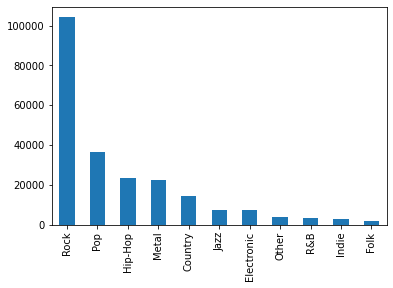

In [ ]:
data['genre'].value_counts().plot(kind = 'bar')

In [ ]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.head()

,genre,lyrics
0,Pop,Oh baby how you doing You know I'm gonna cut r...
1,Pop,playin everything so easy it's like you seem s...
2,Pop,If you search For tenderness It isn't hard to ...
3,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,Pop,Party the people the people the party it's pop...


In [ ]:
import numpy as np
from sklearn import preprocessing as skpp
label_encoder = skpp.LabelEncoder()
data['genre'] = np.array(label_encoder.fit_transform(data['genre'].values))
data.head()

,genre,lyrics
0,8,Oh baby how you doing You know I'm gonna cut r...
1,8,playin everything so easy it's like you seem s...
2,8,If you search For tenderness It isn't hard to ...
3,8,Oh oh oh I oh oh oh I If I wrote a book about ...
4,8,Party the people the people the party it's pop...


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.15, random_state = 100)
train.head()

,genre,lyrics
164267,10,Wish me luck give me somethin' Help me out and...
162051,3,Check one two uh Yeah one two Yeah one two One...
96849,10,Hello boys Got directions to the bombshell fac...
11519,10,Ero solo come un ombrello su una macchina da c...
126349,10,Well my heart's in The Highlands gentle and fa...


In [ ]:
print("Train shape:", train.shape)
print('Test shape:', test.shape)

Train shape: (193331, 2)
Test shape: (34118, 2)


In [ ]:
train.columns

Index(['genre', 'lyrics'], dtype='object')

In [ ]:
train['genre'].unique()

array([10,  3,  1,  8,  6,  0,  7,  9,  4,  5,  2])

In [ ]:
DATA_COLUMN = 'lyrics'
LABEL_COLUMN = 'genre'
label_list = [0,1,2,3,4,5,6,7,8,9,10]

In [ ]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples

164267    <bert.run_classifier.InputExample object at 0x...
162051    <bert.run_classifier.InputExample object at 0x...
96849     <bert.run_classifier.InputExample object at 0x...
11519     <bert.run_classifier.InputExample object at 0x...
126349    <bert.run_classifier.InputExample object at 0x...
                                ...                        
65615     <bert.run_classifier.InputExample object at 0x...
77655     <bert.run_classifier.InputExample object at 0x...
210755    <bert.run_classifier.InputExample object at 0x...
56088     <bert.run_classifier.InputExample object at 0x...
38408     <bert.run_classifier.InputExample object at 0x...
Length: 193331, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  Wish me luck give me somethin' Help me out and I'll go there Wish me luck give me somethin' Help me out and I'll go there All I want is a brand new truck With one eyed jacks and beginners luck The doctors script for the perfect drug Get it all while I can But I got no money and I got no man I drive around in a beat up van I ride on coffee and percodan Get it all while I can get it all while I can Is that too much to ask Is that too much

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  10


In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['This',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'B',
 '##ER',
 '##T',
 'token',
 '##izer']

In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 193331


INFO:tensorflow:Writing example 0 of 193331


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Wish me luck give me some ##thin ' Help me out and I ' ll go there Wish me luck give me some ##thin ' Help me out and I ' ll go there All I want is a brand new truck With one eyed jack ##s and begin ##ners luck The doctors script for the perfect drug Get it all while I can But I got no money and I got no man I drive around in a beat up van I ride on coffee and per ##co ##dan Get it all while I can get it all while I can Is that too much to ask Is that too much [SEP]


INFO:tensorflow:tokens: [CLS] Wish me luck give me some ##thin ' Help me out and I ' ll go there Wish me luck give me some ##thin ' Help me out and I ' ll go there All I want is a brand new truck With one eyed jack ##s and begin ##ners luck The doctors script for the perfect drug Get it all while I can But I got no money and I got no man I drive around in a beat up van I ride on coffee and per ##co ##dan Get it all while I can get it all while I can Is that too much to ask Is that too much [SEP]


INFO:tensorflow:input_ids: 101 18861 1143 6920 1660 1143 1199 24365 112 12056 1143 1149 1105 146 112 1325 1301 1175 18861 1143 6920 1660 1143 1199 24365 112 12056 1143 1149 1105 146 112 1325 1301 1175 1398 146 1328 1110 170 4097 1207 4202 1556 1141 7074 24498 1116 1105 3295 9268 6920 1109 8114 5444 1111 1103 3264 3850 3949 1122 1155 1229 146 1169 1252 146 1400 1185 1948 1105 146 1400 1185 1299 146 2797 1213 1107 170 3222 1146 3498 146 4176 1113 3538 1105 1679 2528 6778 3949 1122 1155 1229 146 1169 1243 1122 1155 1229 146 1169 2181 1115 1315 1277 1106 2367 2181 1115 1315 1277 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 18861 1143 6920 1660 1143 1199 24365 112 12056 1143 1149 1105 146 112 1325 1301 1175 18861 1143 6920 1660 1143 1199 24365 112 12056 1143 1149 1105 146 112 1325 1301 1175 1398 146 1328 1110 170 4097 1207 4202 1556 1141 7074 24498 1116 1105 3295 9268 6920 1109 8114 5444 1111 1103 3264 3850 3949 1122 1155 1229 146 1169 1252 146 1400 1185 1948 1105 146 1400 1185 1299 146 2797 1213 1107 170 3222 1146 3498 146 4176 1113 3538 1105 1679 2528 6778 3949 1122 1155 1229 146 1169 1243 1122 1155 1229 146 1169 2181 1115 1315 1277 1106 2367 2181 1115 1315 1277 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Check one two uh Yeah one two Yeah one two One two one two For the city We stay high stay fly Stay real for real Live good Stay right For the city We stay high stay fly Stay real for real Live good stay right For the city We re ##p the people with honor Put the bomb marijuana Like my mother and father For the city We say peace to the drama Peace out to bad charm ##a Cause peace is what I want For my city Ain ' t never but color thing Just a one love da ##p hug family day [SEP]


INFO:tensorflow:tokens: [CLS] Check one two uh Yeah one two Yeah one two One two one two For the city We stay high stay fly Stay real for real Live good Stay right For the city We stay high stay fly Stay real for real Live good stay right For the city We re ##p the people with honor Put the bomb marijuana Like my mother and father For the city We say peace to the drama Peace out to bad charm ##a Cause peace is what I want For my city Ain ' t never but color thing Just a one love da ##p hug family day [SEP]


INFO:tensorflow:input_ids: 101 23114 1141 1160 14863 2814 1141 1160 2814 1141 1160 1448 1160 1141 1160 1370 1103 1331 1284 2215 1344 2215 4689 9999 1842 1111 1842 3374 1363 9999 1268 1370 1103 1331 1284 2215 1344 2215 4689 9999 1842 1111 1842 3374 1363 2215 1268 1370 1103 1331 1284 1231 1643 1103 1234 1114 3874 11913 1103 5985 18816 2409 1139 1534 1105 1401 1370 1103 1331 1284 1474 3519 1106 1103 3362 5370 1149 1106 2213 11967 1161 20111 3519 1110 1184 146 1328 1370 1139 1331 12088 112 189 1309 1133 2942 1645 2066 170 1141 1567 5358 1643 8363 1266 1285 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 23114 1141 1160 14863 2814 1141 1160 2814 1141 1160 1448 1160 1141 1160 1370 1103 1331 1284 2215 1344 2215 4689 9999 1842 1111 1842 3374 1363 9999 1268 1370 1103 1331 1284 2215 1344 2215 4689 9999 1842 1111 1842 3374 1363 2215 1268 1370 1103 1331 1284 1231 1643 1103 1234 1114 3874 11913 1103 5985 18816 2409 1139 1534 1105 1401 1370 1103 1331 1284 1474 3519 1106 1103 3362 5370 1149 1106 2213 11967 1161 20111 3519 1110 1184 146 1328 1370 1139 1331 12088 112 189 1309 1133 2942 1645 2066 170 1141 1567 5358 1643 8363 1266 1285 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Hello boys Got directions to the bombs ##hell factory And a bow ##fle ##xing nightmare tendency He ##si ##tate Where ' s the tape my retired beauty queen Hello girls Truth can make you stare into the mirror for hours And could lip ##g ##loss save a nation Mr Powers Come into what ' s my own disappear zone Close my ears I close my eyes In the world of a stupid girl And in her stupid dress size So who are we Who ' s the judge And are you something like a hero No mistakes Different versions of the girl right next to you And I ' m knocking on your door and [SEP]


INFO:tensorflow:tokens: [CLS] Hello boys Got directions to the bombs ##hell factory And a bow ##fle ##xing nightmare tendency He ##si ##tate Where ' s the tape my retired beauty queen Hello girls Truth can make you stare into the mirror for hours And could lip ##g ##loss save a nation Mr Powers Come into what ' s my own disappear zone Close my ears I close my eyes In the world of a stupid girl And in her stupid dress size So who are we Who ' s the judge And are you something like a hero No mistakes Different versions of the girl right next to you And I ' m knocking on your door and [SEP]


INFO:tensorflow:input_ids: 101 8667 3287 7348 7768 1106 1103 10095 24364 4790 1262 170 7125 23445 24118 12178 12034 1124 5053 10237 2777 112 188 1103 6649 1139 2623 5295 5746 8667 2636 9907 1169 1294 1128 5698 1154 1103 5220 1111 2005 1262 1180 4764 1403 20831 3277 170 3790 1828 12305 3435 1154 1184 112 188 1139 1319 10489 4834 11145 1139 4942 146 1601 1139 1257 1130 1103 1362 1104 170 4736 1873 1262 1107 1123 4736 3642 2060 1573 1150 1132 1195 2627 112 188 1103 3942 1262 1132 1128 1380 1176 170 6485 1302 12572 14380 3827 1104 1103 1873 1268 1397 1106 1128 1262 146 112 182 10760 1113 1240 1442 1105 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8667 3287 7348 7768 1106 1103 10095 24364 4790 1262 170 7125 23445 24118 12178 12034 1124 5053 10237 2777 112 188 1103 6649 1139 2623 5295 5746 8667 2636 9907 1169 1294 1128 5698 1154 1103 5220 1111 2005 1262 1180 4764 1403 20831 3277 170 3790 1828 12305 3435 1154 1184 112 188 1139 1319 10489 4834 11145 1139 4942 146 1601 1139 1257 1130 1103 1362 1104 170 4736 1873 1262 1107 1123 4736 3642 2060 1573 1150 1132 1195 2627 112 188 1103 3942 1262 1132 1128 1380 1176 170 6485 1302 12572 14380 3827 1104 1103 1873 1268 1397 1106 1128 1262 146 112 182 10760 1113 1240 1442 1105 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] E ##ro solo come un o ##mbre ##llo su un ##a mac ##china da cu ##ci ##re Dal ##le pen ##dic ##i dei mon ##ti I ##ble ##i a set ##ten ##tri ##one Ho per ##cor ##so il ca ##mm ##ino a ##rra ##mp ##ica ##ndo ##mi per un ##ivers ##i e mon ##di con at ##ti di pen ##sie ##ro e um ##ori cerebral ##i L ' a ##bis ##so non mi ch ##iam ##a s ##to su ##l c ##ig ##lio come un c ##es ##pu ##gli ##o quiet ##o come un ins ##etto ch ##e si pre ##nde il sole Sc ##end ##evo lung ##o il fi ##ume scroll ##and ##o le spa ##lle Ch ##e c ##ena in ##fa ##me s ##tase [SEP]


INFO:tensorflow:tokens: [CLS] E ##ro solo come un o ##mbre ##llo su un ##a mac ##china da cu ##ci ##re Dal ##le pen ##dic ##i dei mon ##ti I ##ble ##i a set ##ten ##tri ##one Ho per ##cor ##so il ca ##mm ##ino a ##rra ##mp ##ica ##ndo ##mi per un ##ivers ##i e mon ##di con at ##ti di pen ##sie ##ro e um ##ori cerebral ##i L ' a ##bis ##so non mi ch ##iam ##a s ##to su ##l c ##ig ##lio come un c ##es ##pu ##gli ##o quiet ##o come un ins ##etto ch ##e si pre ##nde il sole Sc ##end ##evo lung ##o il fi ##ume scroll ##and ##o le spa ##lle Ch ##e c ##ena in ##fa ##me s ##tase [SEP]


INFO:tensorflow:input_ids: 101 142 2180 3444 1435 8362 184 20347 6643 28117 8362 1161 23639 22952 5358 16408 6617 1874 25938 1513 8228 13328 1182 21357 19863 3121 146 2165 1182 170 1383 5208 19091 4798 9800 1679 19248 7301 14596 11019 6262 4559 170 10582 8223 4578 13645 3080 1679 8362 25105 1182 174 19863 3309 14255 1120 3121 4267 8228 9819 2180 174 15276 9012 21831 1182 149 112 170 14866 7301 1664 1940 22572 18331 1161 188 2430 28117 1233 172 6512 9436 1435 8362 172 1279 16091 23655 1186 3589 1186 1435 8362 22233 27394 22572 1162 27466 3073 11131 14596 6753 20452 6696 23663 13093 1186 14596 20497 15447 21105 5709 1186 5837 22620 4838 20394 1162 172 7076 1107 8057 3263 188 25347 102


INFO:tensorflow:input_ids: 101 142 2180 3444 1435 8362 184 20347 6643 28117 8362 1161 23639 22952 5358 16408 6617 1874 25938 1513 8228 13328 1182 21357 19863 3121 146 2165 1182 170 1383 5208 19091 4798 9800 1679 19248 7301 14596 11019 6262 4559 170 10582 8223 4578 13645 3080 1679 8362 25105 1182 174 19863 3309 14255 1120 3121 4267 8228 9819 2180 174 15276 9012 21831 1182 149 112 170 14866 7301 1664 1940 22572 18331 1161 188 2430 28117 1233 172 6512 9436 1435 8362 172 1279 16091 23655 1186 3589 1186 1435 8362 22233 27394 22572 1162 27466 3073 11131 14596 6753 20452 6696 23663 13093 1186 14596 20497 15447 21105 5709 1186 5837 22620 4838 20394 1162 172 7076 1107 8057 3263 188 25347 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Well my heart ' s in The Highlands gentle and fair Honey ##su ##ckle b ##loom ##ing in the wild ##wood air Blue ##bell ##s blazing where the Aberdeen waters flow Well my heart ' s in The Highlands I ' m gonna go there when I feel good enough to go Windows were shaking all night in my dreams Everything was exactly the way that it seems W ##oke up this m ##orn ##in and I looked at the same old page Same old rat race life in the same old cage I don ' t want not ##hin from anyone ain ' t that much to take Wouldn ' t know the difference between a real blonde and a fake Feel [SEP]


INFO:tensorflow:tokens: [CLS] Well my heart ' s in The Highlands gentle and fair Honey ##su ##ckle b ##loom ##ing in the wild ##wood air Blue ##bell ##s blazing where the Aberdeen waters flow Well my heart ' s in The Highlands I ' m gonna go there when I feel good enough to go Windows were shaking all night in my dreams Everything was exactly the way that it seems W ##oke up this m ##orn ##in and I looked at the same old page Same old rat race life in the same old cage I don ' t want not ##hin from anyone ain ' t that much to take Wouldn ' t know the difference between a real blonde and a fake Feel [SEP]


INFO:tensorflow:input_ids: 101 2119 1139 1762 112 188 1107 1109 15343 6892 1105 4652 12632 6385 19053 171 13853 1158 1107 1103 4098 2615 1586 2770 14545 1116 20013 1187 1103 12184 5635 4235 2119 1139 1762 112 188 1107 1109 15343 146 112 182 6100 1301 1175 1165 146 1631 1363 1536 1106 1301 5647 1127 5121 1155 1480 1107 1139 6149 5268 1108 2839 1103 1236 1115 1122 3093 160 9143 1146 1142 182 8456 1394 1105 146 1350 1120 1103 1269 1385 3674 14060 1385 11631 1886 1297 1107 1103 1269 1385 10096 146 1274 112 189 1328 1136 8265 1121 2256 9562 112 189 1115 1277 1106 1321 20487 112 189 1221 1103 3719 1206 170 1842 9853 1105 170 8406 14425 102 0 0 0


INFO:tensorflow:input_ids: 101 2119 1139 1762 112 188 1107 1109 15343 6892 1105 4652 12632 6385 19053 171 13853 1158 1107 1103 4098 2615 1586 2770 14545 1116 20013 1187 1103 12184 5635 4235 2119 1139 1762 112 188 1107 1109 15343 146 112 182 6100 1301 1175 1165 146 1631 1363 1536 1106 1301 5647 1127 5121 1155 1480 1107 1139 6149 5268 1108 2839 1103 1236 1115 1122 3093 160 9143 1146 1142 182 8456 1394 1105 146 1350 1120 1103 1269 1385 3674 14060 1385 11631 1886 1297 1107 1103 1269 1385 10096 146 1274 112 189 1328 1136 8265 1121 2256 9562 112 189 1115 1277 1106 1321 20487 112 189 1221 1103 3719 1206 170 1842 9853 1105 170 8406 14425 102 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:Writing example 10000 of 193331


INFO:tensorflow:Writing example 10000 of 193331


INFO:tensorflow:Writing example 20000 of 193331


INFO:tensorflow:Writing example 20000 of 193331


INFO:tensorflow:Writing example 30000 of 193331


INFO:tensorflow:Writing example 30000 of 193331


INFO:tensorflow:Writing example 40000 of 193331


INFO:tensorflow:Writing example 40000 of 193331


INFO:tensorflow:Writing example 50000 of 193331


INFO:tensorflow:Writing example 50000 of 193331


INFO:tensorflow:Writing example 60000 of 193331


INFO:tensorflow:Writing example 60000 of 193331


INFO:tensorflow:Writing example 70000 of 193331


INFO:tensorflow:Writing example 70000 of 193331


INFO:tensorflow:Writing example 80000 of 193331


INFO:tensorflow:Writing example 80000 of 193331


INFO:tensorflow:Writing example 90000 of 193331


INFO:tensorflow:Writing example 90000 of 193331


INFO:tensorflow:Writing example 100000 of 193331


INFO:tensorflow:Writing example 100000 of 193331


INFO:tensorflow:Writing example 110000 of 193331


INFO:tensorflow:Writing example 110000 of 193331


INFO:tensorflow:Writing example 120000 of 193331


INFO:tensorflow:Writing example 120000 of 193331


INFO:tensorflow:Writing example 130000 of 193331


INFO:tensorflow:Writing example 130000 of 193331


INFO:tensorflow:Writing example 140000 of 193331


INFO:tensorflow:Writing example 140000 of 193331


INFO:tensorflow:Writing example 150000 of 193331


INFO:tensorflow:Writing example 150000 of 193331


INFO:tensorflow:Writing example 160000 of 193331


INFO:tensorflow:Writing example 160000 of 193331


INFO:tensorflow:Writing example 170000 of 193331


INFO:tensorflow:Writing example 170000 of 193331


INFO:tensorflow:Writing example 180000 of 193331


INFO:tensorflow:Writing example 180000 of 193331


INFO:tensorflow:Writing example 190000 of 193331


INFO:tensorflow:Writing example 190000 of 193331


INFO:tensorflow:Writing example 0 of 34118


INFO:tensorflow:Writing example 0 of 34118


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] I ' m awake in a sleepy old town Streets deserted there ' s no one around Don ' t care where I ' m going Don ' t know where I ' ve been Don ' t know how it started or how it will end That ' s the life of a born ram ##blin man I met a girl from the town of no where I couldn ' t stay got restless back there I don ' t blame her for giving Lord I needed her then She knew my way of living Wild and free as the wind That ' s the life of a born ram ##blin man If the plans that I made yesterday Fall apart on some [SEP]


INFO:tensorflow:tokens: [CLS] I ' m awake in a sleepy old town Streets deserted there ' s no one around Don ' t care where I ' m going Don ' t know where I ' ve been Don ' t know how it started or how it will end That ' s the life of a born ram ##blin man I met a girl from the town of no where I couldn ' t stay got restless back there I don ' t blame her for giving Lord I needed her then She knew my way of living Wild and free as the wind That ' s the life of a born ram ##blin man If the plans that I made yesterday Fall apart on some [SEP]


INFO:tensorflow:input_ids: 101 146 112 182 8264 1107 170 23024 1385 1411 11433 13180 1175 112 188 1185 1141 1213 1790 112 189 1920 1187 146 112 182 1280 1790 112 189 1221 1187 146 112 1396 1151 1790 112 189 1221 1293 1122 1408 1137 1293 1122 1209 1322 1337 112 188 1103 1297 1104 170 1255 26084 17529 1299 146 1899 170 1873 1121 1103 1411 1104 1185 1187 146 1577 112 189 2215 1400 20806 1171 1175 146 1274 112 189 7338 1123 1111 2368 2188 146 1834 1123 1173 1153 1450 1139 1236 1104 1690 5469 1105 1714 1112 1103 3223 1337 112 188 1103 1297 1104 170 1255 26084 17529 1299 1409 1103 2714 1115 146 1189 8128 6760 3966 1113 1199 102 0 0


INFO:tensorflow:input_ids: 101 146 112 182 8264 1107 170 23024 1385 1411 11433 13180 1175 112 188 1185 1141 1213 1790 112 189 1920 1187 146 112 182 1280 1790 112 189 1221 1187 146 112 1396 1151 1790 112 189 1221 1293 1122 1408 1137 1293 1122 1209 1322 1337 112 188 1103 1297 1104 170 1255 26084 17529 1299 146 1899 170 1873 1121 1103 1411 1104 1185 1187 146 1577 112 189 2215 1400 20806 1171 1175 146 1274 112 189 7338 1123 1111 2368 2188 146 1834 1123 1173 1153 1450 1139 1236 1104 1690 5469 1105 1714 1112 1103 3223 1337 112 188 1103 1297 1104 170 1255 26084 17529 1299 1409 1103 2714 1115 146 1189 8128 6760 3966 1113 1199 102 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Can ' t stop the wave of sorrow Every while that you go G ##im ##me this night G ##im ##me G ##im ##me this night G ##im ##me Can ' t stop the wave of sorrow Every while that you go Come home Rep ##eat 4 ##X This night of joy follows Oh everywhere you go Can ' t stop the wave of sorrow Every while that you go Come home Rep ##eat 4 ##X This night of joy follows Oh everywhere you go This night of joy Oh everywhere you go Come home Come home Come home [SEP]


INFO:tensorflow:tokens: [CLS] Can ' t stop the wave of sorrow Every while that you go G ##im ##me this night G ##im ##me G ##im ##me this night G ##im ##me Can ' t stop the wave of sorrow Every while that you go Come home Rep ##eat 4 ##X This night of joy follows Oh everywhere you go Can ' t stop the wave of sorrow Every while that you go Come home Rep ##eat 4 ##X This night of joy follows Oh everywhere you go This night of joy Oh everywhere you go Come home Come home Come home [SEP]


INFO:tensorflow:input_ids: 101 2825 112 189 1831 1103 4003 1104 17359 4081 1229 1115 1128 1301 144 4060 3263 1142 1480 144 4060 3263 144 4060 3263 1142 1480 144 4060 3263 2825 112 189 1831 1103 4003 1104 17359 4081 1229 1115 1128 1301 3435 1313 20777 13448 125 3190 1188 1480 1104 8730 3226 2048 7244 1128 1301 2825 112 189 1831 1103 4003 1104 17359 4081 1229 1115 1128 1301 3435 1313 20777 13448 125 3190 1188 1480 1104 8730 3226 2048 7244 1128 1301 1188 1480 1104 8730 2048 7244 1128 1301 3435 1313 3435 1313 3435 1313 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2825 112 189 1831 1103 4003 1104 17359 4081 1229 1115 1128 1301 144 4060 3263 1142 1480 144 4060 3263 144 4060 3263 1142 1480 144 4060 3263 2825 112 189 1831 1103 4003 1104 17359 4081 1229 1115 1128 1301 3435 1313 20777 13448 125 3190 1188 1480 1104 8730 3226 2048 7244 1128 1301 2825 112 189 1831 1103 4003 1104 17359 4081 1229 1115 1128 1301 3435 1313 20777 13448 125 3190 1188 1480 1104 8730 3226 2048 7244 1128 1301 1188 1480 1104 8730 2048 7244 1128 1301 3435 1313 3435 1313 3435 1313 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:label: 10 (id = 10)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting [SEP]


INFO:tensorflow:tokens: [CLS] Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting me high Your love keeps lifting me high Li ##fting [SEP]


INFO:tensorflow:input_ids: 101 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 1143 1344 2353 1567 7634 9219 1143 1344 5255 16364 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Under pressure Under control Fe ##eding the living With the limbs of the dead Long before the dawn ##ing Long ##ing for the fall Hell we keep the motor humming I am humming running dry Black on fire arrows Ai ##ming in the sky Search ##ing for a shelter home Hi ##ding from each other ' s pain Wake me take me Turn around and hate me I may not be good company But I can kill your a ##pathy Near the end of the stay Near the bottom of the line We all follow the animal And escape the pain Now tell me more about the girl That [SEP]


INFO:tensorflow:tokens: [CLS] Under pressure Under control Fe ##eding the living With the limbs of the dead Long before the dawn ##ing Long ##ing for the fall Hell we keep the motor humming I am humming running dry Black on fire arrows Ai ##ming in the sky Search ##ing for a shelter home Hi ##ding from each other ' s pain Wake me take me Turn around and hate me I may not be good company But I can kill your a ##pathy Near the end of the stay Near the bottom of the line We all follow the animal And escape the pain Now tell me more about the girl That [SEP]


INFO:tensorflow:input_ids: 101 2831 2997 2831 1654 11907 17141 1103 1690 1556 1103 10765 1104 1103 2044 3261 1196 1103 9623 1158 3261 1158 1111 1103 2303 5479 1195 1712 1103 5968 23474 146 1821 23474 1919 3712 2117 1113 1783 15130 19294 5031 1107 1103 3901 12646 1158 1111 170 7890 1313 8790 3408 1121 1296 1168 112 188 2489 13062 1143 1321 1143 12128 1213 1105 4819 1143 146 1336 1136 1129 1363 1419 1252 146 1169 2311 1240 170 12233 9669 1103 1322 1104 1103 2215 9669 1103 3248 1104 1103 1413 1284 1155 2812 1103 3724 1262 3359 1103 2489 1986 1587 1143 1167 1164 1103 1873 1337 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2831 2997 2831 1654 11907 17141 1103 1690 1556 1103 10765 1104 1103 2044 3261 1196 1103 9623 1158 3261 1158 1111 1103 2303 5479 1195 1712 1103 5968 23474 146 1821 23474 1919 3712 2117 1113 1783 15130 19294 5031 1107 1103 3901 12646 1158 1111 170 7890 1313 8790 3408 1121 1296 1168 112 188 2489 13062 1143 1321 1143 12128 1213 1105 4819 1143 146 1336 1136 1129 1363 1419 1252 146 1169 2311 1240 170 12233 9669 1103 1322 1104 1103 2215 9669 1103 3248 1104 1103 1413 1284 1155 2812 1103 3724 1262 3359 1103 2489 1986 1587 1143 1167 1164 1103 1873 1337 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] My body will be set a ##f ##lam ##e tonight Even though my heart will remain It ' s cold as ice inside I feel my fists are buried in the pavement Help ##less to the rotting cancer sent to ruin my life I awake to this anxiety That every breath every step might be my last I feel I ' m growing numb A slight chill to my flesh Like one million knives St ##ab ##bing a hole right through my chest There is no comfort My surroundings bleak as night The angels of death awaiting for me to lock me in their sights Life ##less I fear the wrath [SEP]


INFO:tensorflow:tokens: [CLS] My body will be set a ##f ##lam ##e tonight Even though my heart will remain It ' s cold as ice inside I feel my fists are buried in the pavement Help ##less to the rotting cancer sent to ruin my life I awake to this anxiety That every breath every step might be my last I feel I ' m growing numb A slight chill to my flesh Like one million knives St ##ab ##bing a hole right through my chest There is no comfort My surroundings bleak as night The angels of death awaiting for me to lock me in their sights Life ##less I fear the wrath [SEP]


INFO:tensorflow:input_ids: 101 1422 1404 1209 1129 1383 170 2087 7609 1162 3568 2431 1463 1139 1762 1209 3118 1135 112 188 2504 1112 2854 1656 146 1631 1139 9993 1132 3126 1107 1103 15823 12056 2008 1106 1103 25407 4182 1850 1106 10677 1139 1297 146 8264 1106 1142 10507 1337 1451 2184 1451 2585 1547 1129 1139 1314 146 1631 146 112 182 2898 18152 138 6812 11824 1106 1139 5352 2409 1141 1550 14726 1457 6639 6791 170 4569 1268 1194 1139 2229 1247 1110 1185 7238 1422 11342 26481 1112 1480 1109 13266 1104 1473 16794 1111 1143 1106 5842 1143 1107 1147 17504 2583 2008 146 2945 1103 23127 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1422 1404 1209 1129 1383 170 2087 7609 1162 3568 2431 1463 1139 1762 1209 3118 1135 112 188 2504 1112 2854 1656 146 1631 1139 9993 1132 3126 1107 1103 15823 12056 2008 1106 1103 25407 4182 1850 1106 10677 1139 1297 146 8264 1106 1142 10507 1337 1451 2184 1451 2585 1547 1129 1139 1314 146 1631 146 112 182 2898 18152 138 6812 11824 1106 1139 5352 2409 1141 1550 14726 1457 6639 6791 170 4569 1268 1194 1139 2229 1247 1110 1185 7238 1422 11342 26481 1112 1480 1109 13266 1104 1473 16794 1111 1143 1106 5842 1143 1107 1147 17504 2583 2008 146 2945 1103 23127 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:Writing example 10000 of 34118


INFO:tensorflow:Writing example 10000 of 34118


INFO:tensorflow:Writing example 20000 of 34118


INFO:tensorflow:Writing example 20000 of 34118


INFO:tensorflow:Writing example 30000 of 34118


INFO:tensorflow:Writing example 30000 of 34118


In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  Wish me luck give me somethin' Help me out and I'll go there Wish me luck give me somethin' Help me out and I'll go there All I want is a brand new truck With one eyed jacks and beginners luck The doctors script for the perfect drug Get it all while I can But I got no money and I got no man I drive around in a beat up van I ride on coffee and percodan Get it all while I can get it all while I can Is that too much to ask Is that too much
------------------------------
Tokens :  ['Wish', 'me', 'luck', 'give', 'me', 'some', '##thin', "'", 'Help', 'me', 'out', 'and', 'I', "'", 'll', 'go', 'there', 'Wish', 'me', 'luck', 'give', 'me', 'some', '##thin', "'", 'Help', 'me', 'out', 'and', 'I', "'", 'll', 'go', 'there', 'All', 'I', 'want', 'is', 'a', 'brand', 'new', 'truck', 'With', 'one', 'eyed', 'jack', '##s', 'and', 'begin', '##ners', 'luck', 'The', 'doctors', 'script', 'for', 'the', 'perfect', 'drug', 'Get', 'it', 'all', 'while', 'I', 'can', 'But', 'I', 'got', 'no', 'money', 'and'

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa8b2cdf080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa8b2cdf080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/model.ckpt.


INFO:tensorflow:loss = 2.4524713, step = 0


INFO:tensorflow:loss = 2.4524713, step = 0


INFO:tensorflow:global_step/sec: 0.539088


INFO:tensorflow:global_step/sec: 0.539088


INFO:tensorflow:loss = 1.7409338, step = 100 (185.501 sec)


INFO:tensorflow:loss = 1.7409338, step = 100 (185.501 sec)


INFO:tensorflow:global_step/sec: 0.582853


INFO:tensorflow:global_step/sec: 0.582853


INFO:tensorflow:loss = 1.3939072, step = 200 (171.570 sec)


INFO:tensorflow:loss = 1.3939072, step = 200 (171.570 sec)


INFO:tensorflow:Saving checkpoints for 300 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553937


INFO:tensorflow:global_step/sec: 0.553937


INFO:tensorflow:loss = 1.5962784, step = 300 (180.527 sec)


INFO:tensorflow:loss = 1.5962784, step = 300 (180.527 sec)


INFO:tensorflow:global_step/sec: 0.581902


INFO:tensorflow:global_step/sec: 0.581902


INFO:tensorflow:loss = 1.0192403, step = 400 (171.851 sec)


INFO:tensorflow:loss = 1.0192403, step = 400 (171.851 sec)


INFO:tensorflow:global_step/sec: 0.58259


INFO:tensorflow:global_step/sec: 0.58259


INFO:tensorflow:loss = 1.4832392, step = 500 (171.648 sec)


INFO:tensorflow:loss = 1.4832392, step = 500 (171.648 sec)


INFO:tensorflow:Saving checkpoints for 600 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554251


INFO:tensorflow:global_step/sec: 0.554251


INFO:tensorflow:loss = 1.2392855, step = 600 (180.423 sec)


INFO:tensorflow:loss = 1.2392855, step = 600 (180.423 sec)


INFO:tensorflow:global_step/sec: 0.582049


INFO:tensorflow:global_step/sec: 0.582049


INFO:tensorflow:loss = 1.1168197, step = 700 (171.806 sec)


INFO:tensorflow:loss = 1.1168197, step = 700 (171.806 sec)


INFO:tensorflow:global_step/sec: 0.583733


INFO:tensorflow:global_step/sec: 0.583733


INFO:tensorflow:loss = 1.3531165, step = 800 (171.313 sec)


INFO:tensorflow:loss = 1.3531165, step = 800 (171.313 sec)


INFO:tensorflow:Saving checkpoints for 900 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554184


INFO:tensorflow:global_step/sec: 0.554184


INFO:tensorflow:loss = 1.2436638, step = 900 (180.443 sec)


INFO:tensorflow:loss = 1.2436638, step = 900 (180.443 sec)


INFO:tensorflow:global_step/sec: 0.581627


INFO:tensorflow:global_step/sec: 0.581627


INFO:tensorflow:loss = 1.2046492, step = 1000 (171.931 sec)


INFO:tensorflow:loss = 1.2046492, step = 1000 (171.931 sec)


INFO:tensorflow:global_step/sec: 0.582225


INFO:tensorflow:global_step/sec: 0.582225


INFO:tensorflow:loss = 1.2017498, step = 1100 (171.755 sec)


INFO:tensorflow:loss = 1.2017498, step = 1100 (171.755 sec)


INFO:tensorflow:Saving checkpoints for 1200 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553699


INFO:tensorflow:global_step/sec: 0.553699


INFO:tensorflow:loss = 1.328178, step = 1200 (180.605 sec)


INFO:tensorflow:loss = 1.328178, step = 1200 (180.605 sec)


INFO:tensorflow:global_step/sec: 0.582272


INFO:tensorflow:global_step/sec: 0.582272


INFO:tensorflow:loss = 1.2767026, step = 1300 (171.740 sec)


INFO:tensorflow:loss = 1.2767026, step = 1300 (171.740 sec)


INFO:tensorflow:global_step/sec: 0.583989


INFO:tensorflow:global_step/sec: 0.583989


INFO:tensorflow:loss = 1.3727231, step = 1400 (171.238 sec)


INFO:tensorflow:loss = 1.3727231, step = 1400 (171.238 sec)


INFO:tensorflow:Saving checkpoints for 1500 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 0.553077


INFO:tensorflow:global_step/sec: 0.553077


INFO:tensorflow:loss = 1.228824, step = 1500 (180.807 sec)


INFO:tensorflow:loss = 1.228824, step = 1500 (180.807 sec)


INFO:tensorflow:global_step/sec: 0.582991


INFO:tensorflow:global_step/sec: 0.582991


INFO:tensorflow:loss = 1.0463786, step = 1600 (171.529 sec)


INFO:tensorflow:loss = 1.0463786, step = 1600 (171.529 sec)


INFO:tensorflow:global_step/sec: 0.583348


INFO:tensorflow:global_step/sec: 0.583348


INFO:tensorflow:loss = 1.1627417, step = 1700 (171.424 sec)


INFO:tensorflow:loss = 1.1627417, step = 1700 (171.424 sec)


INFO:tensorflow:Saving checkpoints for 1800 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554746


INFO:tensorflow:global_step/sec: 0.554746


INFO:tensorflow:loss = 1.1347537, step = 1800 (180.263 sec)


INFO:tensorflow:loss = 1.1347537, step = 1800 (180.263 sec)


INFO:tensorflow:global_step/sec: 0.582252


INFO:tensorflow:global_step/sec: 0.582252


INFO:tensorflow:loss = 1.3250549, step = 1900 (171.744 sec)


INFO:tensorflow:loss = 1.3250549, step = 1900 (171.744 sec)


INFO:tensorflow:global_step/sec: 0.58342


INFO:tensorflow:global_step/sec: 0.58342


INFO:tensorflow:loss = 1.1215254, step = 2000 (171.407 sec)


INFO:tensorflow:loss = 1.1215254, step = 2000 (171.407 sec)


INFO:tensorflow:Saving checkpoints for 2100 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2100 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552564


INFO:tensorflow:global_step/sec: 0.552564


INFO:tensorflow:loss = 1.2595705, step = 2100 (180.972 sec)


INFO:tensorflow:loss = 1.2595705, step = 2100 (180.972 sec)


INFO:tensorflow:global_step/sec: 0.581299


INFO:tensorflow:global_step/sec: 0.581299


INFO:tensorflow:loss = 1.0482466, step = 2200 (172.027 sec)


INFO:tensorflow:loss = 1.0482466, step = 2200 (172.027 sec)


INFO:tensorflow:global_step/sec: 0.584061


INFO:tensorflow:global_step/sec: 0.584061


INFO:tensorflow:loss = 1.1990526, step = 2300 (171.217 sec)


INFO:tensorflow:loss = 1.1990526, step = 2300 (171.217 sec)


INFO:tensorflow:Saving checkpoints for 2400 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2400 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554584


INFO:tensorflow:global_step/sec: 0.554584


INFO:tensorflow:loss = 1.2250966, step = 2400 (180.313 sec)


INFO:tensorflow:loss = 1.2250966, step = 2400 (180.313 sec)


INFO:tensorflow:global_step/sec: 0.582365


INFO:tensorflow:global_step/sec: 0.582365


INFO:tensorflow:loss = 1.2493167, step = 2500 (171.714 sec)


INFO:tensorflow:loss = 1.2493167, step = 2500 (171.714 sec)


INFO:tensorflow:global_step/sec: 0.583387


INFO:tensorflow:global_step/sec: 0.583387


INFO:tensorflow:loss = 0.99349177, step = 2600 (171.414 sec)


INFO:tensorflow:loss = 0.99349177, step = 2600 (171.414 sec)


INFO:tensorflow:Saving checkpoints for 2700 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2700 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554566


INFO:tensorflow:global_step/sec: 0.554566


INFO:tensorflow:loss = 1.4566623, step = 2700 (180.323 sec)


INFO:tensorflow:loss = 1.4566623, step = 2700 (180.323 sec)


INFO:tensorflow:global_step/sec: 0.581899


INFO:tensorflow:global_step/sec: 0.581899


INFO:tensorflow:loss = 1.3001513, step = 2800 (171.849 sec)


INFO:tensorflow:loss = 1.3001513, step = 2800 (171.849 sec)


INFO:tensorflow:global_step/sec: 0.58428


INFO:tensorflow:global_step/sec: 0.58428


INFO:tensorflow:loss = 1.5129206, step = 2900 (171.149 sec)


INFO:tensorflow:loss = 1.5129206, step = 2900 (171.149 sec)


INFO:tensorflow:Saving checkpoints for 3000 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.55307


INFO:tensorflow:global_step/sec: 0.55307


INFO:tensorflow:loss = 1.2053074, step = 3000 (180.809 sec)


INFO:tensorflow:loss = 1.2053074, step = 3000 (180.809 sec)


INFO:tensorflow:global_step/sec: 0.581604


INFO:tensorflow:global_step/sec: 0.581604


INFO:tensorflow:loss = 1.4919846, step = 3100 (171.942 sec)


INFO:tensorflow:loss = 1.4919846, step = 3100 (171.942 sec)


INFO:tensorflow:global_step/sec: 0.583104


INFO:tensorflow:global_step/sec: 0.583104


INFO:tensorflow:loss = 0.981446, step = 3200 (171.493 sec)


INFO:tensorflow:loss = 0.981446, step = 3200 (171.493 sec)


INFO:tensorflow:Saving checkpoints for 3300 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3300 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553173


INFO:tensorflow:global_step/sec: 0.553173


INFO:tensorflow:loss = 0.99583167, step = 3300 (180.775 sec)


INFO:tensorflow:loss = 0.99583167, step = 3300 (180.775 sec)


INFO:tensorflow:global_step/sec: 0.581959


INFO:tensorflow:global_step/sec: 0.581959


INFO:tensorflow:loss = 0.9816687, step = 3400 (171.834 sec)


INFO:tensorflow:loss = 0.9816687, step = 3400 (171.834 sec)


INFO:tensorflow:global_step/sec: 0.583395


INFO:tensorflow:global_step/sec: 0.583395


INFO:tensorflow:loss = 0.85857713, step = 3500 (171.411 sec)


INFO:tensorflow:loss = 0.85857713, step = 3500 (171.411 sec)


INFO:tensorflow:Saving checkpoints for 3600 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3600 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553256


INFO:tensorflow:global_step/sec: 0.553256


INFO:tensorflow:loss = 1.102825, step = 3600 (180.751 sec)


INFO:tensorflow:loss = 1.102825, step = 3600 (180.751 sec)


INFO:tensorflow:global_step/sec: 0.581954


INFO:tensorflow:global_step/sec: 0.581954


INFO:tensorflow:loss = 0.7891592, step = 3700 (171.832 sec)


INFO:tensorflow:loss = 0.7891592, step = 3700 (171.832 sec)


INFO:tensorflow:global_step/sec: 0.582512


INFO:tensorflow:global_step/sec: 0.582512


INFO:tensorflow:loss = 0.9809991, step = 3800 (171.671 sec)


INFO:tensorflow:loss = 0.9809991, step = 3800 (171.671 sec)


INFO:tensorflow:Saving checkpoints for 3900 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3900 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.55485


INFO:tensorflow:global_step/sec: 0.55485


INFO:tensorflow:loss = 0.7929108, step = 3900 (180.228 sec)


INFO:tensorflow:loss = 0.7929108, step = 3900 (180.228 sec)


INFO:tensorflow:global_step/sec: 0.58226


INFO:tensorflow:global_step/sec: 0.58226


INFO:tensorflow:loss = 0.86191404, step = 4000 (171.746 sec)


INFO:tensorflow:loss = 0.86191404, step = 4000 (171.746 sec)


INFO:tensorflow:global_step/sec: 0.584858


INFO:tensorflow:global_step/sec: 0.584858


INFO:tensorflow:loss = 0.8210715, step = 4100 (170.979 sec)


INFO:tensorflow:loss = 0.8210715, step = 4100 (170.979 sec)


INFO:tensorflow:Saving checkpoints for 4200 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4200 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553047


INFO:tensorflow:global_step/sec: 0.553047


INFO:tensorflow:loss = 0.88266397, step = 4200 (180.818 sec)


INFO:tensorflow:loss = 0.88266397, step = 4200 (180.818 sec)


INFO:tensorflow:global_step/sec: 0.582461


INFO:tensorflow:global_step/sec: 0.582461


INFO:tensorflow:loss = 1.0171695, step = 4300 (171.687 sec)


INFO:tensorflow:loss = 1.0171695, step = 4300 (171.687 sec)


INFO:tensorflow:global_step/sec: 0.582081


INFO:tensorflow:global_step/sec: 0.582081


INFO:tensorflow:loss = 0.8689807, step = 4400 (171.795 sec)


INFO:tensorflow:loss = 0.8689807, step = 4400 (171.795 sec)


INFO:tensorflow:Saving checkpoints for 4500 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4500 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554622


INFO:tensorflow:global_step/sec: 0.554622


INFO:tensorflow:loss = 0.6889242, step = 4500 (180.305 sec)


INFO:tensorflow:loss = 0.6889242, step = 4500 (180.305 sec)


INFO:tensorflow:global_step/sec: 0.581866


INFO:tensorflow:global_step/sec: 0.581866


INFO:tensorflow:loss = 1.0950395, step = 4600 (171.861 sec)


INFO:tensorflow:loss = 1.0950395, step = 4600 (171.861 sec)


INFO:tensorflow:global_step/sec: 0.58301


INFO:tensorflow:global_step/sec: 0.58301


INFO:tensorflow:loss = 1.1368306, step = 4700 (171.524 sec)


INFO:tensorflow:loss = 1.1368306, step = 4700 (171.524 sec)


INFO:tensorflow:Saving checkpoints for 4800 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4800 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553682


INFO:tensorflow:global_step/sec: 0.553682


INFO:tensorflow:loss = 0.757776, step = 4800 (180.609 sec)


INFO:tensorflow:loss = 0.757776, step = 4800 (180.609 sec)


INFO:tensorflow:global_step/sec: 0.582203


INFO:tensorflow:global_step/sec: 0.582203


INFO:tensorflow:loss = 0.9599129, step = 4900 (171.760 sec)


INFO:tensorflow:loss = 0.9599129, step = 4900 (171.760 sec)


INFO:tensorflow:global_step/sec: 0.583157


INFO:tensorflow:global_step/sec: 0.583157


INFO:tensorflow:loss = 0.9365703, step = 5000 (171.482 sec)


INFO:tensorflow:loss = 0.9365703, step = 5000 (171.482 sec)


INFO:tensorflow:Saving checkpoints for 5100 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5100 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554451


INFO:tensorflow:global_step/sec: 0.554451


INFO:tensorflow:loss = 0.8246887, step = 5100 (180.358 sec)


INFO:tensorflow:loss = 0.8246887, step = 5100 (180.358 sec)


INFO:tensorflow:global_step/sec: 0.581984


INFO:tensorflow:global_step/sec: 0.581984


INFO:tensorflow:loss = 0.99524724, step = 5200 (171.825 sec)


INFO:tensorflow:loss = 0.99524724, step = 5200 (171.825 sec)


INFO:tensorflow:global_step/sec: 0.582346


INFO:tensorflow:global_step/sec: 0.582346


INFO:tensorflow:loss = 0.72373277, step = 5300 (171.721 sec)


INFO:tensorflow:loss = 0.72373277, step = 5300 (171.721 sec)


INFO:tensorflow:Saving checkpoints for 5400 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5400 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552598


INFO:tensorflow:global_step/sec: 0.552598


INFO:tensorflow:loss = 1.018246, step = 5400 (180.962 sec)


INFO:tensorflow:loss = 1.018246, step = 5400 (180.962 sec)


INFO:tensorflow:global_step/sec: 0.58173


INFO:tensorflow:global_step/sec: 0.58173


INFO:tensorflow:loss = 1.0114694, step = 5500 (171.902 sec)


INFO:tensorflow:loss = 1.0114694, step = 5500 (171.902 sec)


INFO:tensorflow:global_step/sec: 0.581928


INFO:tensorflow:global_step/sec: 0.581928


INFO:tensorflow:loss = 0.8811741, step = 5600 (171.842 sec)


INFO:tensorflow:loss = 0.8811741, step = 5600 (171.842 sec)


INFO:tensorflow:Saving checkpoints for 5700 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5700 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552561


INFO:tensorflow:global_step/sec: 0.552561


INFO:tensorflow:loss = 0.9014604, step = 5700 (180.977 sec)


INFO:tensorflow:loss = 0.9014604, step = 5700 (180.977 sec)


INFO:tensorflow:global_step/sec: 0.582028


INFO:tensorflow:global_step/sec: 0.582028


INFO:tensorflow:loss = 0.894777, step = 5800 (171.813 sec)


INFO:tensorflow:loss = 0.894777, step = 5800 (171.813 sec)


INFO:tensorflow:global_step/sec: 0.582428


INFO:tensorflow:global_step/sec: 0.582428


INFO:tensorflow:loss = 0.65030956, step = 5900 (171.694 sec)


INFO:tensorflow:loss = 0.65030956, step = 5900 (171.694 sec)


INFO:tensorflow:Saving checkpoints for 6000 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554061


INFO:tensorflow:global_step/sec: 0.554061


INFO:tensorflow:loss = 0.8110818, step = 6000 (180.488 sec)


INFO:tensorflow:loss = 0.8110818, step = 6000 (180.488 sec)


INFO:tensorflow:global_step/sec: 0.582344


INFO:tensorflow:global_step/sec: 0.582344


INFO:tensorflow:loss = 0.97179586, step = 6100 (171.720 sec)


INFO:tensorflow:loss = 0.97179586, step = 6100 (171.720 sec)


INFO:tensorflow:global_step/sec: 0.582911


INFO:tensorflow:global_step/sec: 0.582911


INFO:tensorflow:loss = 0.70660734, step = 6200 (171.550 sec)


INFO:tensorflow:loss = 0.70660734, step = 6200 (171.550 sec)


INFO:tensorflow:Saving checkpoints for 6300 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6300 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552822


INFO:tensorflow:global_step/sec: 0.552822


INFO:tensorflow:loss = 0.74971676, step = 6300 (180.891 sec)


INFO:tensorflow:loss = 0.74971676, step = 6300 (180.891 sec)


INFO:tensorflow:global_step/sec: 0.581877


INFO:tensorflow:global_step/sec: 0.581877


INFO:tensorflow:loss = 0.68247914, step = 6400 (171.857 sec)


INFO:tensorflow:loss = 0.68247914, step = 6400 (171.857 sec)


INFO:tensorflow:global_step/sec: 0.584054


INFO:tensorflow:global_step/sec: 0.584054


INFO:tensorflow:loss = 0.62090623, step = 6500 (171.218 sec)


INFO:tensorflow:loss = 0.62090623, step = 6500 (171.218 sec)


INFO:tensorflow:Saving checkpoints for 6600 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6600 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553257


INFO:tensorflow:global_step/sec: 0.553257


INFO:tensorflow:loss = 0.97571325, step = 6600 (180.746 sec)


INFO:tensorflow:loss = 0.97571325, step = 6600 (180.746 sec)


INFO:tensorflow:global_step/sec: 0.581497


INFO:tensorflow:global_step/sec: 0.581497


INFO:tensorflow:loss = 0.6517723, step = 6700 (171.970 sec)


INFO:tensorflow:loss = 0.6517723, step = 6700 (171.970 sec)


INFO:tensorflow:global_step/sec: 0.582363


INFO:tensorflow:global_step/sec: 0.582363


INFO:tensorflow:loss = 1.005835, step = 6800 (171.714 sec)


INFO:tensorflow:loss = 1.005835, step = 6800 (171.714 sec)


INFO:tensorflow:Saving checkpoints for 6900 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6900 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.549438


INFO:tensorflow:global_step/sec: 0.549438


INFO:tensorflow:loss = 0.82206476, step = 6900 (182.007 sec)


INFO:tensorflow:loss = 0.82206476, step = 6900 (182.007 sec)


INFO:tensorflow:global_step/sec: 0.581713


INFO:tensorflow:global_step/sec: 0.581713


INFO:tensorflow:loss = 0.31324378, step = 7000 (171.904 sec)


INFO:tensorflow:loss = 0.31324378, step = 7000 (171.904 sec)


INFO:tensorflow:global_step/sec: 0.582755


INFO:tensorflow:global_step/sec: 0.582755


INFO:tensorflow:loss = 0.9033135, step = 7100 (171.600 sec)


INFO:tensorflow:loss = 0.9033135, step = 7100 (171.600 sec)


INFO:tensorflow:Saving checkpoints for 7200 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7200 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552993


INFO:tensorflow:global_step/sec: 0.552993


INFO:tensorflow:loss = 0.43071806, step = 7200 (180.835 sec)


INFO:tensorflow:loss = 0.43071806, step = 7200 (180.835 sec)


INFO:tensorflow:global_step/sec: 0.582357


INFO:tensorflow:global_step/sec: 0.582357


INFO:tensorflow:loss = 0.62131447, step = 7300 (171.715 sec)


INFO:tensorflow:loss = 0.62131447, step = 7300 (171.715 sec)


INFO:tensorflow:global_step/sec: 0.582755


INFO:tensorflow:global_step/sec: 0.582755


INFO:tensorflow:loss = 0.6623955, step = 7400 (171.601 sec)


INFO:tensorflow:loss = 0.6623955, step = 7400 (171.601 sec)


INFO:tensorflow:Saving checkpoints for 7500 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7500 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553308


INFO:tensorflow:global_step/sec: 0.553308


INFO:tensorflow:loss = 0.5651342, step = 7500 (180.729 sec)


INFO:tensorflow:loss = 0.5651342, step = 7500 (180.729 sec)


INFO:tensorflow:global_step/sec: 0.582159


INFO:tensorflow:global_step/sec: 0.582159


INFO:tensorflow:loss = 0.87357855, step = 7600 (171.777 sec)


INFO:tensorflow:loss = 0.87357855, step = 7600 (171.777 sec)


INFO:tensorflow:global_step/sec: 0.583257


INFO:tensorflow:global_step/sec: 0.583257


INFO:tensorflow:loss = 1.0059705, step = 7700 (171.452 sec)


INFO:tensorflow:loss = 1.0059705, step = 7700 (171.452 sec)


INFO:tensorflow:Saving checkpoints for 7800 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7800 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552794


INFO:tensorflow:global_step/sec: 0.552794


INFO:tensorflow:loss = 0.42555612, step = 7800 (180.896 sec)


INFO:tensorflow:loss = 0.42555612, step = 7800 (180.896 sec)


INFO:tensorflow:global_step/sec: 0.58184


INFO:tensorflow:global_step/sec: 0.58184


INFO:tensorflow:loss = 0.3793028, step = 7900 (171.869 sec)


INFO:tensorflow:loss = 0.3793028, step = 7900 (171.869 sec)


INFO:tensorflow:global_step/sec: 0.581373


INFO:tensorflow:global_step/sec: 0.581373


INFO:tensorflow:loss = 0.74425226, step = 8000 (172.010 sec)


INFO:tensorflow:loss = 0.74425226, step = 8000 (172.010 sec)


INFO:tensorflow:Saving checkpoints for 8100 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8100 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.5531


INFO:tensorflow:global_step/sec: 0.5531


INFO:tensorflow:loss = 0.45016122, step = 8100 (180.797 sec)


INFO:tensorflow:loss = 0.45016122, step = 8100 (180.797 sec)


INFO:tensorflow:global_step/sec: 0.581344


INFO:tensorflow:global_step/sec: 0.581344


INFO:tensorflow:loss = 0.58865714, step = 8200 (172.013 sec)


INFO:tensorflow:loss = 0.58865714, step = 8200 (172.013 sec)


INFO:tensorflow:global_step/sec: 0.582625


INFO:tensorflow:global_step/sec: 0.582625


INFO:tensorflow:loss = 0.56859666, step = 8300 (171.639 sec)


INFO:tensorflow:loss = 0.56859666, step = 8300 (171.639 sec)


INFO:tensorflow:Saving checkpoints for 8400 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8400 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.552701


INFO:tensorflow:global_step/sec: 0.552701


INFO:tensorflow:loss = 0.59111404, step = 8400 (180.930 sec)


INFO:tensorflow:loss = 0.59111404, step = 8400 (180.930 sec)


INFO:tensorflow:global_step/sec: 0.58143


INFO:tensorflow:global_step/sec: 0.58143


INFO:tensorflow:loss = 0.570239, step = 8500 (171.990 sec)


INFO:tensorflow:loss = 0.570239, step = 8500 (171.990 sec)


INFO:tensorflow:global_step/sec: 0.58283


INFO:tensorflow:global_step/sec: 0.58283


INFO:tensorflow:loss = 0.63821596, step = 8600 (171.575 sec)


INFO:tensorflow:loss = 0.63821596, step = 8600 (171.575 sec)


INFO:tensorflow:Saving checkpoints for 8700 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8700 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.553036


INFO:tensorflow:global_step/sec: 0.553036


INFO:tensorflow:loss = 0.65538704, step = 8700 (180.821 sec)


INFO:tensorflow:loss = 0.65538704, step = 8700 (180.821 sec)


INFO:tensorflow:global_step/sec: 0.581698


INFO:tensorflow:global_step/sec: 0.581698


INFO:tensorflow:loss = 0.69738656, step = 8800 (171.910 sec)


INFO:tensorflow:loss = 0.69738656, step = 8800 (171.910 sec)


INFO:tensorflow:global_step/sec: 0.582347


INFO:tensorflow:global_step/sec: 0.582347


INFO:tensorflow:loss = 0.68550915, step = 8900 (171.724 sec)


INFO:tensorflow:loss = 0.68550915, step = 8900 (171.724 sec)


INFO:tensorflow:Saving checkpoints for 9000 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/model.ckpt.


INFO:tensorflow:global_step/sec: 0.554525


INFO:tensorflow:global_step/sec: 0.554525


INFO:tensorflow:loss = 0.5735833, step = 9000 (180.332 sec)


INFO:tensorflow:loss = 0.5735833, step = 9000 (180.332 sec)


INFO:tensorflow:Saving checkpoints for 9062 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9062 into /content/model.ckpt.


INFO:tensorflow:Loss for final step: 0.45753813.


INFO:tensorflow:Loss for final step: 0.45753813.


Training took time  4:26:48.313623


In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-09-09T01:14:04Z


INFO:tensorflow:Starting evaluation at 2020-09-09T01:14:04Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/model.ckpt-9062


INFO:tensorflow:Restoring parameters from /content/model.ckpt-9062


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-09-09-01:19:27


INFO:tensorflow:Finished evaluation at 2020-09-09-01:19:27


INFO:tensorflow:Saving dict for global step 9062: eval_accuracy = 0.6218712, false_negatives = 883.0, false_positives = 1121.0, global_step = 9062, loss = 1.2771709, true_negatives = 1055.0, true_positives = 31059.0


INFO:tensorflow:Saving dict for global step 9062: eval_accuracy = 0.6218712, false_negatives = 883.0, false_positives = 1121.0, global_step = 9062, loss = 1.2771709, true_negatives = 1055.0, true_positives = 31059.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9062: /content/model.ckpt-9062


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9062: /content/model.ckpt-9062


{'eval_accuracy': 0.6218712,
 'false_negatives': 883.0,
 'false_positives': 1121.0,
 'global_step': 9062,
 'loss': 1.2771709,
 'true_negatives': 1055.0,
 'true_positives': 31059.0}